# 2. Pocking at Ever Larger Language Models
## An introduction for (digital) humanists


## Pretrained Language Models (10 mins)

- Transition from N-Gram to Neural Language Models (ca. 2013)

- [Don't count, predict!](https://aclanthology.org/P14-1023.pdf) (when **training** a language model)

## Terminology
- Parameters are "knobs" you can adjust to transform an input to the output you want
- Deep Learning algorithms attempt to find the optimal setting of these knobs. The more knobs to more complex stuff you can do (but equally, it becomes harder to understand how the machine actually works).
![simpleNN](https://miro.medium.com/v2/resize:fit:624/1*U3FfvaDbIjr7VobJj89fCQ.png)

- LM pretraining and fine-tuning (Why it works better)

## Common PLM variants
- Causal/Autoregressive language models (GPT series): Predict the next [BLANK]
- Masked Language Models (BERT and family): Predict the [BLANK] word.


## Text Generation with GPT-2

While more complex, GPT-2 operates similarly to our simple N-Gram LM.
- Given a prompt, it computes the probability over the following word
- Then we sample a word from this distribution, add it to the prompt and repeat!

Materials inspired by this [blog post](https://huggingface.co/blog/how-to-generate) and the excellent Programming Historian lesson.


In [15]:
!pip install transformers xformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Next word prediction with GPT-2

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Model
import numpy as np
from torch.nn import Softmax
import pandas as pd

In [1]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# add the EOS token as PAD token to avoid warnings
model = GPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

In [2]:
# load the gpt-2 model
gpt2 = GPT2Model.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

In [3]:
prompt = 'Hello my names is' # define a prompt
input_ids = tokenizer.encode(prompt, return_tensors='pt') # tokenize prompt as input for language model
input_ids

tensor([[15496,   616,  3891,   318]])

In [4]:
predictions = model(**tokenizer(prompt, return_tensors='pt')) # get logits from model

In [5]:
predictions.logits.shape # the predictions as logits

torch.Size([1, 4, 50257])

In [39]:
# get words with highest probability
tokenizer.decode(np.argmax(predictions.logits[0,-1,:].detach().numpy()))

' John'

<Axes: >

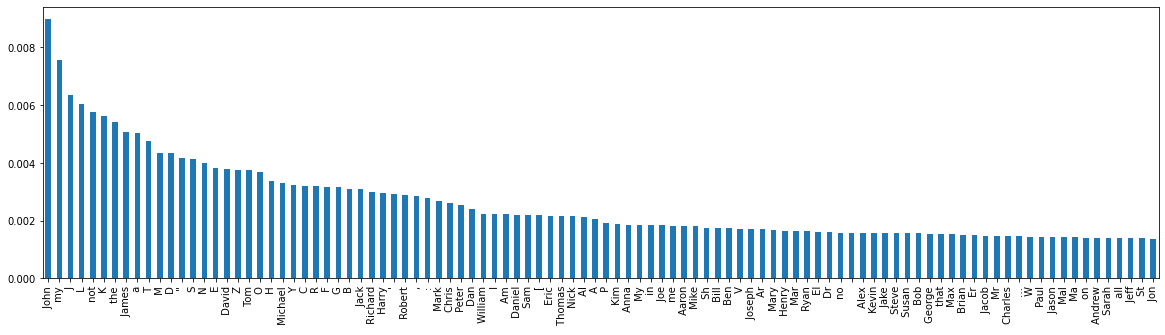

In [41]:
softmax = Softmax(dim=0) # load softmax function
series = pd.Series(softmax(predictions.logits[0,-1,:]).detach()).sort_values(ascending=False)
index = [tokenizer.decode(x) for x in series.index] # change index to tokens
series.index = index # set tokens as index
series[:100].plot(kind='bar',figsize=(20,5)) # plot results

## Generating texts from prompts

In [43]:
#sequence = 'the duke of'
#sequence = 'A no deal Brexit'
sequence = 'The UK is'

In [44]:
from transformers import pipeline
generator = pipeline('text-generation', model = 'gpt2',pad_token_id=tokenizer.eos_token_id)
generator(sequence, max_length = 30, num_return_sequences=10)

/Users/kasparbeelen/anaconda3/envs/sas-llm/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


[{'generated_text': 'The UK is looking to raise £2,500 as a starting point for the £100m funding plan over a nine-year period but is not'},
 {'generated_text': 'The UK is to provide services to countries with the highest quality of life.\n\nThe ESR-7 also works to ensure that the United Kingdom'},
 {'generated_text': 'The UK is one of the two biggest companies to receive investment by an investment bank, with £6.6bn coming from Deutsche Bank.\n\n'},
 {'generated_text': 'The UK is already experiencing the first real surge in its coal use in more than 40 years, with a new round of new coal-fired power stations'},
 {'generated_text': 'The UK is "actively" preparing contingency plans to deal with a number of "troubling developments", though no further conclusions have been drawn by the'},
 {'generated_text': 'The UK is still going through an extremely disappointing period since I began making this analysis more than a year ago. But the EU vote to leave the EU'},
 {'generated_text': 'The UK

Increasing the temperature can make predictions more creative (or random if you [like](https://medium.com/mlearning-ai/softmax-temperature-5492e4007f71#:~:text=Temperature%20is%20a%20hyperparameter%20of%20LSTMs%20(and%20neural%20networks%20generally,utilize%20the%20Softmax%20decision%20layer.)))

![temperature](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*7xj72SjtNHvCMQlV.jpeg)

Image taken for this [blog post](https://medium.com/mlearning-ai/softmax-temperature-5492e4007f71#:~:text=Temperature%20is%20a%20hyperparameter%20of%20LSTMs%20(and%20neural%20networks%20generally,utilize%20the%20Softmax%20decision%20layer.) on temperature in Softmax.

In [53]:
import torch
torch.manual_seed(0)
generator(sequence, 
          max_length = 30, 
          num_return_sequences=5,
          do_sample=True, 
          top_k = 0,
          temperature=.000000001, # change temparature to .7
         )


[{'generated_text': 'The UK is the only country in the world that does not have a national health service.\n\nThe NHS is the only country in the world that'},
 {'generated_text': 'The UK is the only country in the world that does not have a national health service.\n\nThe NHS is the only country in the world that'},
 {'generated_text': 'The UK is the only country in the world that does not have a national health service.\n\nThe NHS is the only country in the world that'},
 {'generated_text': 'The UK is the only country in the world that does not have a national health service.\n\nThe NHS is the only country in the world that'},
 {'generated_text': 'The UK is the only country in the world that does not have a national health service.\n\nThe NHS is the only country in the world that'}]

### Top k sampling

In [56]:
generator(sequence, 
          max_length = 30, 
          do_sample=True, 
          num_return_sequences=2,
         
          top_k=50)

[{'generated_text': "The UK is the world's first, and largest supplier of UK-made medical marijuana, after a company in China developed a highly-efficient, fully"},
 {'generated_text': 'The UK is leading the fight for an independent Brexit."\n\nThe Labour Party\'s Shadow Brexit Secretary and current Home Secretary, Andrea Leadsom,'}]

### Top p of nucleus sampling

In [58]:
generator(sequence, 
          max_length = 30, 
          do_sample=True, 
          num_return_sequences=2,
          top_k=0,
          top_p=.92)

[{'generated_text': 'The UK is an independent province which does not recognise any specific nation or country in common. These are distinct countries of residence in the Union under the E'},
 {'generated_text': "The UK is preparing to launch 'flagship' nuclear power stations which would run for at least 10 years before it goes down the power chain, where"}]

## Adapting a language model

Building a GPT-Brexit model on top of GPT-2.

Question: How does it change the behaviour of this model?

In [49]:
from transformers import pipeline
generator = pipeline('text-generation', model = 'Kaspar/gpt-brexit',tokenizer='gpt2',pad_token_id=tokenizer.eos_token_id)
generator(sequence, max_length = 30, num_return_sequences=10)

[{'generated_text': 'The UK is already more than three-quarters of the way through the legal phase of talks. If Brexit talks end on October 31, they go through'},
 {'generated_text': 'The UK is set to leave the EU for six months from the 29th Feb with no deal - though the EU - on 31 October it will be'},
 {'generated_text': 'The UK is not the only European country to be affected by a disruption to the border between Northern Ireland and the Republic of Ireland. This is likely to'},
 {'generated_text': 'The UK is set to leave the EU on 29 March 2019.\nThe transition period is the length of the transition period to allow for a smooth transition'},
 {'generated_text': 'The UK is at "a crossroads" in its Brexit negotiations.\nThe EU said it would only provide assurances about the country\'s legal status after'},
 {'generated_text': 'The UK is in an economic and social limbo with no clear plan at the moment.\n"With time running out and a trade deal so far under'},
 {'generated_text': 'The U

# Bias and Toxicity in PLM (and LLMs)

An excellent [HuggingFace tutorial](https://colab.research.google.com/drive/1-HDJUcPMKEF-E7Hapih0OmA1xTW2hdAv#scrollTo=MOsHUjgdIrIW) to be integrated later.

# Masked Language Models and History 

In [59]:
from transformers import pipeline
sentences = "In a word, servants must be treated, not as [MASK] , but as human beings who are always more in clined to act according to their immediate personal interest than according to the dictates of high morality."

masker = pipeline("fill-mask", model='bert-base-uncased')
masker(sentences)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[{'score': 0.6143149137496948,
  'token': 8858,
  'token_str': 'servants',
  'sequence': 'in a word, servants must be treated, not as servants, but as human beings who are always more in clined to act according to their immediate personal interest than according to the dictates of high morality.'},
 {'score': 0.038304492831230164,
  'token': 7179,
  'token_str': 'slaves',
  'sequence': 'in a word, servants must be treated, not as slaves, but as human beings who are always more in clined to act according to their immediate personal interest than according to the dictates of high morality.'},
 {'score': 0.03722238168120384,
  'token': 4176,
  'token_str': 'animals',
  'sequence': 'in a word, servants must be treated, not as animals, but as human beings who are always more in clined to act according to their immediate personal interest than according to the dictates of high morality.'},
 {'score': 0.02273709885776043,
  'token': 2111,
  'token_str': 'people',
  'sequence': 'in a word, ser

In [60]:
from transformers import pipeline

victorian_masker = pipeline("fill-mask", model='Livingwithmachines/bert_1760_1900')
victorian_masker(sentences)

NameError: name 'sentences' is not defined

# Fin.